# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [614]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [615]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Loaded {}".format(sheet_name))

Loaded M3Month


1. Change the first index to which timeseries you want.

In [616]:
# Start from the 7th column (index 6) 
category_data = data[data['Category'].str.strip() == category]
series = category_data.iloc[0, 6:].dropna().astype(float)  

2. Here we take the first monthly timeseries in the category of finance. We plot it alongside its 2nd degree polynomial trend.

Selected series length: 143 time points
Training size: 131, Validation size: 12


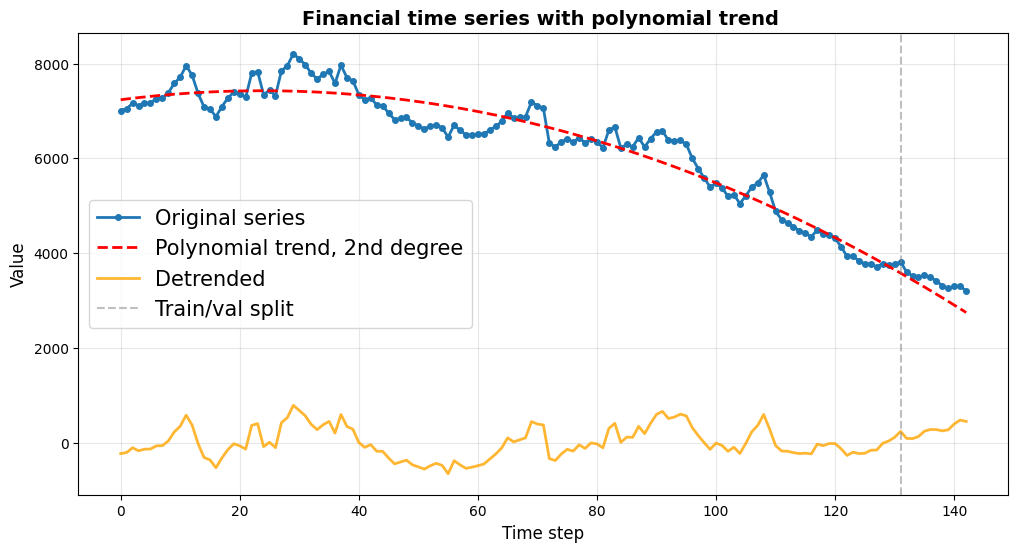

In [617]:

print(f"Selected series length: {len(series)} time points")

# We split before the polynomial 
y = series.values
train_size = len(y) - 12  # last 12 for validation

# Fits polynomial trend on the trianing data
poly = PolynomialFeatures(degree=2)
X_train_indices = np.arange(train_size).reshape(-1, 1)
X_all_indices = np.arange(len(y)).reshape(-1, 1)

x_poly_train = poly.fit_transform(X_train_indices)
poly_model = LinearRegression()
poly_model.fit(x_poly_train, y[:train_size])  

# Apply the trend to the entire series and detrend
x_poly_all = poly.transform(X_all_indices)
poly_trend = poly_model.predict(x_poly_all)
de_trended = y - poly_trend

print(f"Training size: {train_size}, Validation size: 12")

plt.figure(figsize=(12, 6))
plt.plot(series.values, marker='o', linewidth=2, markersize=4, label='Original series')
plt.plot(poly_trend, color='red', linewidth=2, label='Polynomial trend, 2nd degree', linestyle='--')
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.8)
plt.axvline(train_size, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Train/val split')

plt.title("Financial time series with polynomial trend ", fontsize=14, fontweight='bold')
plt.legend(fontsize=15)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

3. Next up is de-trending and de-seasonalizing the timeseries to prepare the input for the MLP

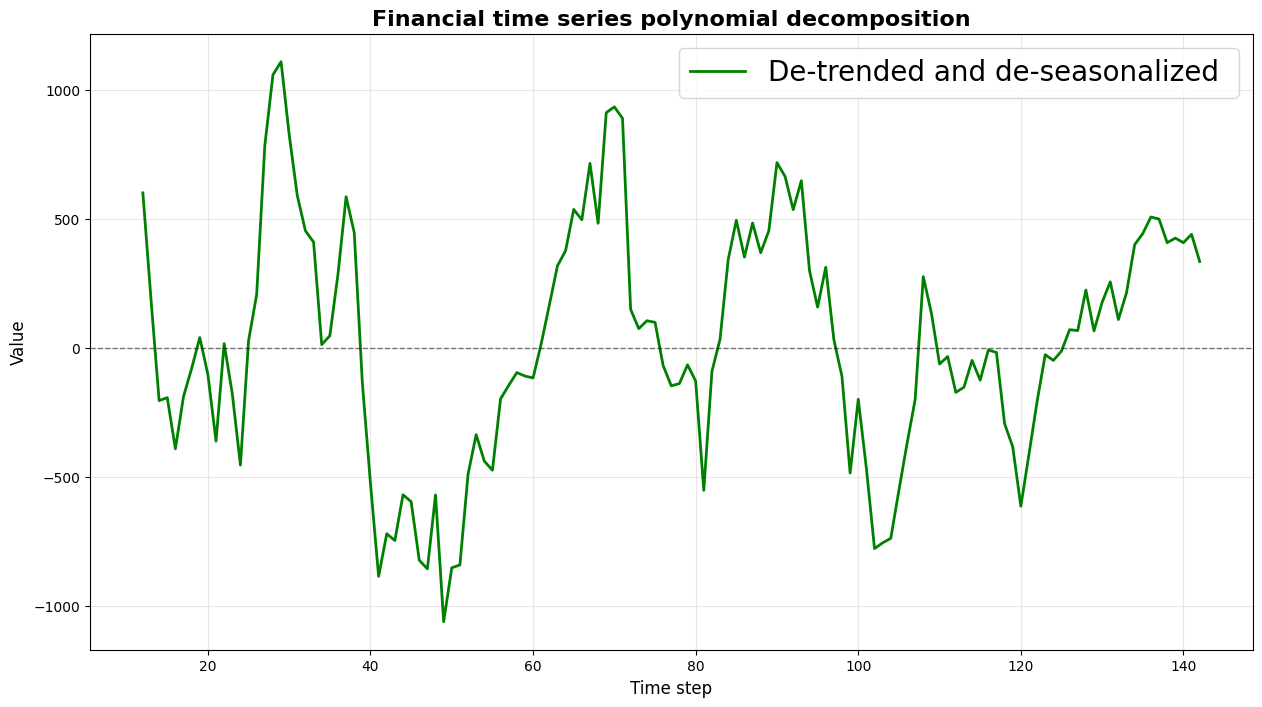

In [618]:
# Removes the seasonal 12 month seasonal component
seasonal_component = np.zeros(len(de_trended))
months_in_year = 12
seasonal_diff = list()

for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

# Seasonal component calculation
for m in range(months_in_year):
    month_indices = np.arange(m, len(de_trended), months_in_year)
    month_mean = np.mean(de_trended[month_indices])
    seasonal_component[month_indices] = month_mean


# remove hashtag for whichever plot you want to see
plt.figure(figsize=(15, 8))
#plt.plot(range(len(y)), y, 'b-', linewidth=2, label='Original', alpha=0.8) # original series
#plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.5) # detrended series
plt.plot(range(months_in_year, len(de_trended)), seasonal_diff, 'green', linewidth=2, label='De-trended and de-seasonalized ') # detrended + seasonal differenced series
#plt.plot(range(len(seasonal_component)), seasonal_component, 'purple', linewidth=2, label='Seasonal ', alpha=0.8) # seasonal component

plt.title("Financial time series polynomial decomposition", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)  
plt.show()



4. The data is scaled before being used as input. We also save the last 12 months of the timeseries to use for validation of our model

In [619]:
from sklearn.preprocessing import StandardScaler

# split before scaling so that validation data wont influence the scaler
seasonal_diff_array = np.array(seasonal_diff)
train_portion = seasonal_diff_array[:-12]  # All except last 12
validation_portion = seasonal_diff_array[-12:]  # Last 12

# Scale only the training data
scaler = StandardScaler()
scaler.fit(train_portion.reshape(-1, 1))

# Transform both using the same scaler
training_data = scaler.transform(train_portion.reshape(-1, 1)).flatten()
validation_data = scaler.transform(validation_portion.reshape(-1, 1)).flatten()    

# Function to create sequences for the model. Given the last 12 months (x), predict the next month (y)
def create_sequences(data, lookback):

    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_data, lookback=12)

print(f"Training data length: {len(training_data)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Training Mean: {training_data.mean():.18f}, Training Std: {training_data.std():.6f}")


Training data length: 119
X_train shape: (107, 12)
y_train shape: (107,)
Training Mean: 0.000000000000000005, Training Std: 1.000000


5. Class for the multilayer perceptron

In [620]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, l2_lambda=0.0):
        
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  
        self.losses = []

    # In our implementation we chose the tanh activation function for the hidden layer
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation function
        self.hidden_input = X @ self.weight_hidden + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # No activation function for the output, since we are doing regression
        self.final_input = self.hidden_output @ self.weight_output + self.bias_output
        self.final_output = self.final_input  
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # sample size
        
        # reshape to match output shape
        y = y.reshape(-1, 1)
        
        output_error = output - y  
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # weights and bias update with L2 regularization
        self.weight_output -= self.learning_rate * (np.dot(self.hidden_output.T, output_error) / m + (self.l2_lambda / m) * self.weight_output)
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * (np.dot(X.T, hidden_error) / m + (self.l2_lambda / m) * self.weight_hidden)
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, patience=None, min_delta=1e-6):
   
        best_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in tqdm(range(epochs), desc="Training progress"):

            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # MSE
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            
            # L2 regularization for loss
            if self.l2_lambda > 0:
                l2_penalty = (self.l2_lambda / (2 * m)) * (np.sum(self.weight_hidden ** 2) + np.sum(self.weight_output ** 2))
                total_loss = loss + l2_penalty
                self.losses.append(total_loss)
            else:
                self.losses.append(loss)

            # Early stopping to avoid unnecessary training
            if patience is not None:
                if loss < best_loss - min_delta:
                    best_loss = loss
                    patience_counter = 0

                    # Save best weights
                    best_weights = {
                        'weight_hidden': self.weight_hidden.copy(),
                        'weight_output': self.weight_output.copy(),
                        'bias_hidden': self.bias_hidden.copy(),
                        'bias_output': self.bias_output.copy()
                    }
                else:
                    patience_counter += 1
                
                # Stop if patience exceeded
                if patience_counter >= patience:
                    tqdm.write(f"\nEarly stopping at epoch {epoch+1}")
                    tqdm.write(f"Best loss: {best_loss:.6f}")

                    # Restore best weights
                    if best_weights:
                        self.weight_hidden = best_weights['weight_hidden']
                        self.weight_output = best_weights['weight_output']
                        self.bias_hidden = best_weights['bias_hidden']
                        self.bias_output = best_weights['bias_output']
                    break
            
            # Progress updates
            if (epoch+1) % 100000 == 0:
                if patience is not None:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{patience}")
                else:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")

        tqdm.write(f"Final loss: {loss:.10f}")
        
    def predict(self, X):
        output = self.forward(X)
        return output.flatten()
    


6. Initialize the MLP and train it

In [621]:
model = MLP(input_size=12, hidden_size=5, output_size=1, learning_rate=5e-4)
model.train(X_train, y_train, epochs=50000, patience=5000, min_delta=1e-6)

Training progress: 100%|██████████| 50000/50000 [00:01<00:00, 26239.23it/s]

Final loss: 0.1868072759


7. Each prediction is used as input for the next, simulating real-world forecasting where only our predictions are available.

In [622]:
def forecast_multiple_steps(model, last_sequence, n_steps=12):
  
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        
        # Removes oldest component and appends the predicted value
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

# Get last 12 values from training data to start forecasting
last_sequence = training_data[-12:]
validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=12)



8. Reversing to original scale and adding back trend and seasonality

In [623]:

# denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

# detrended values for the validation perdiod
reference_values = de_trended[-(24):-12]

# add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

# Gets trend values for the validation period 
validation_trend = poly_trend[-12:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend


9. Metrics of the prediction. Mean squared error and mean absolute percentage error.

In [624]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-12:]) ** 2)
original_mape = np.mean(np.abs((validation_predictions_original - y[-12:]) / y[-12:])) * 100
original_mae = np.mean(np.abs(validation_predictions_original - y[-12:]))

print(f"Mean squared error:  {original_mse:.2f}")
print(f"Mean absolute error: {original_mae:.2f}")
print(f"Mean absolute percentage error: {original_mape:.2f}%")


print("#"*60)

# Month by month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 13),
    'Actual': y[-12:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-12:],
    'Pct_Error': ((validation_predictions_original - y[-12:]) / y[-12:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

Mean squared error:  11304.72
Mean absolute error: 79.67
Mean absolute percentage error: 2.29%
############################################################

Month-by-Month Comparison:
 Month  Actual   Predicted      Error  Pct_Error
     1  3820.0 3872.212841  52.212841   1.366828
     2  3600.1 3846.075492 245.975492   6.832463
     3  3522.1 3735.587632 213.487632   6.061373
     4  3493.9 3542.642217  48.742217   1.395066
     5  3531.7 3604.775881  73.075881   2.069142
     6  3492.7 3526.560035  33.860035   0.969452
     7  3414.9 3429.638790  14.738790   0.431602
     8  3312.0 3384.807990  72.807990   2.198309
     9  3257.2 3288.625842  31.425842   0.964812
    10  3304.1 3326.999488  22.899488   0.693063
    11  3306.9 3223.868331 -83.031669  -2.510861
    12  3199.7 3135.960689 -63.739311  -1.992040


10. Plot of the financial forecasting

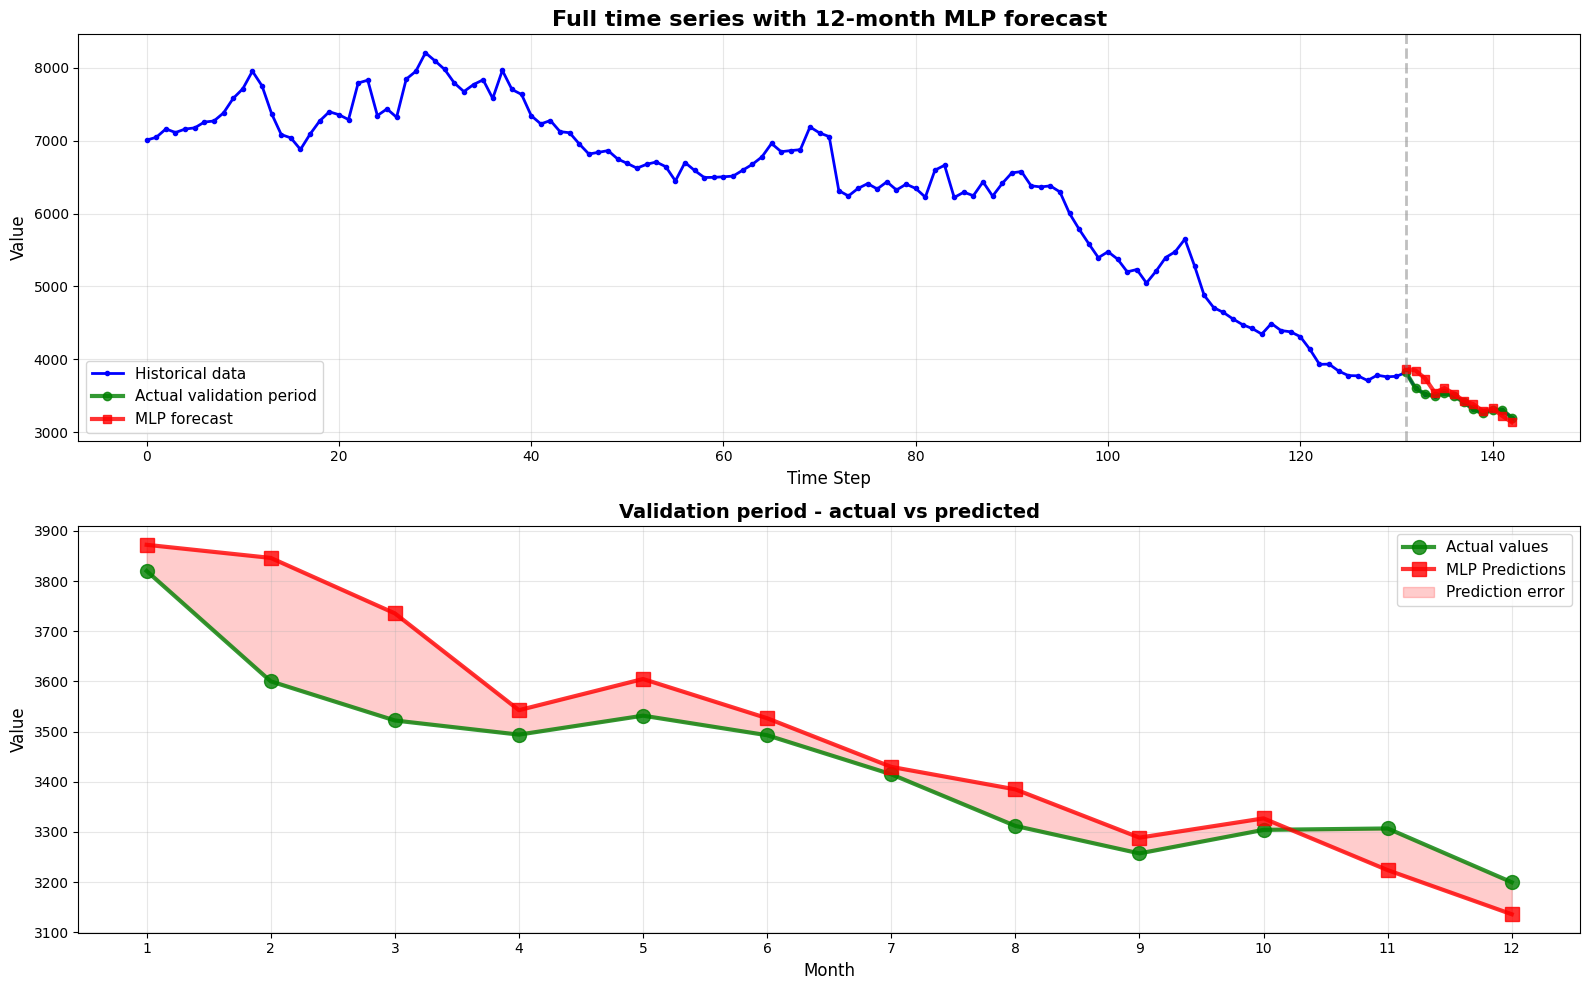

In [625]:
# Full time eries with forecast 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Full series
ax1.plot(range(len(y)), y, 'b-', linewidth=2, label='Historical data', marker='o', markersize=3)
ax1.plot(range(len(y) - 12, len(y)), y[-12:], 'go-', linewidth=3, 
         markersize=6, label='Actual validation period', alpha=0.8)
ax1.plot(range(len(y) - 12, len(y)), validation_predictions_original, 'rs-', 
         linewidth=3, markersize=6, label='MLP forecast', alpha=0.8)
ax1.axvline(len(y) - 12, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_title('Full time series with 12-month MLP forecast', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Zoomed in on validation
months = np.arange(1, 13)
ax2.plot(months, y[-12:], 'go-', linewidth=3, markersize=10, 
         label='Actual values', alpha=0.8)
ax2.plot(months, validation_predictions_original, 'rs-', linewidth=3, 
         markersize=10, label='MLP Predictions', alpha=0.8)
ax2.fill_between(months, y[-12:], validation_predictions_original, 
                  alpha=0.2, color='red', label='Prediction error')
ax2.set_title('Validation period - actual vs predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()